In [33]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['__xarray_dataarray_variable__']
G_CDR_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']


In [35]:
G_ds = xr.concat([G_ds, -G_CDR_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))
G_ds.name = 'G[tas]'
G_ds = G_ds.rename({'year':'s'})


In [36]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = {'UKESM1_r1': 0.25, 'UKESM1_r2': 0.25, 'UKESM1_r3': 0.25, 'UKESM1_r4': 0.25, 'NORESM2': 1, 'GFDL': 1,
       'MIROC': 1, 'ACCESS': 1,  'CANESM5_r2p2':1/3, 'CANESM5_r1p2':1/3, 'CANESM5_r3p2':1/3}
model_weights = xr.DataArray(
    data=list(model_weights.values()),
    dims=["model"],
    coords=dict(
        model=(["model"], list(model_weights.keys()))
    ),
    attrs=dict(
        description="weights for models"
    ),
)

In [37]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

In [38]:
A = utils.find_area(ds_out)

In [46]:
GF = G_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']) #.weighted(A).mean(dim = ['lat','lon'])

In [47]:
df_emis = pd.read_excel('en_roads_co2_emis_example.xlsx', header = 1, index_col = 0)


In [48]:
kgCO2_to_kgC = 1/3.67 #kg to kg
dt = 1 #year

In [49]:
## convert to GtC from GtCO2/year
df_emis = df_emis * kgCO2_to_kgC * dt

In [51]:
%%time
conv_enroads = {}

for nm in list(df_emis.columns):   
    conv_enroads[nm] = signal.convolve(np.array(df_emis[nm].values)[..., None, None], np.array(GF), 'full')
    conv_enroads[nm] = utils.np_to_xr(conv_enroads[nm], GF, df_emis[nm].values)

CPU times: user 990 ms, sys: 507 ms, total: 1.5 s
Wall time: 1.5 s


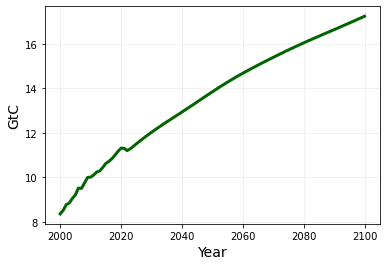

In [90]:
fig, ax = plt.subplots()
plt.plot(df_emis['Baseline'], color = 'darkgreen', linewidth = 3)
plt.ylabel('GtC', fontsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.grid(alpha = 0.2)

In [88]:
for t in np.arange(0,51):
    fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

    ##########1pct exp##################

    (conv_enroads['Baseline']).isel(s = t).plot(ax = ax, 
                                                  cmap = 'RdBu_r',  extend = 'both', vmin = -4, vmax = 4,
                                                  add_colorbar = True,  cbar_kwargs = {'label':'$\Delta$ T ($\degree$ C)'},   
                                                  transform = ccrs.PlateCarree())
    ax.coastlines()
    plt.title(f'{t} years')
    plt.savefig(f'./figures/enroads_video/{t:04d}.png', bbox_inches = 'tight', dpi = 150)
    plt.close()


Text(0.5, 1.0, '')

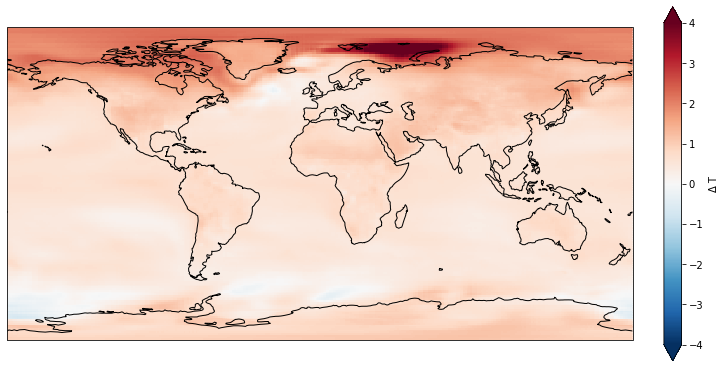

In [82]:
t = 50
fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

##########1pct exp##################

(conv_enroads['Current Scenario']).isel(s = t).plot(ax = ax, 
                                              cmap = 'RdBu_r',  extend = 'both', vmin = -4, vmax = 4, 
                                              add_colorbar = True,  cbar_kwargs = {'label':'$\Delta$ T'},   
                                              transform = ccrs.PlateCarree())
ax.coastlines()
plt.title(None)

Text(0.5, 1.0, '')

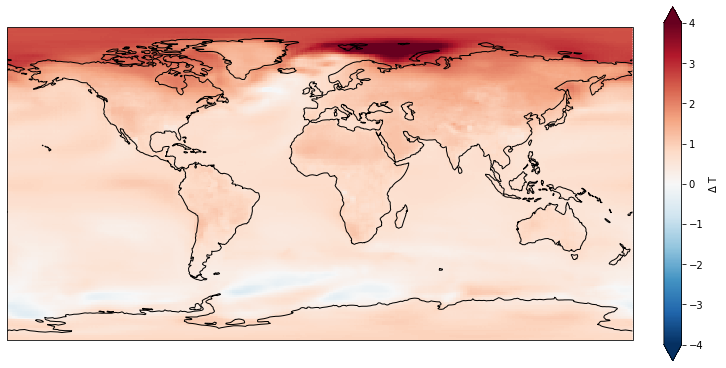

In [83]:
t = 80
fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

##########1pct exp##################

(conv_enroads['Current Scenario'] ).isel(s = t).plot(ax = ax, 
                                              cmap = 'RdBu_r',  extend = 'both', vmin = -4, vmax = 4, 
                                              add_colorbar = True,  cbar_kwargs = {'label':'$\Delta$ T'},   
                                              transform = ccrs.PlateCarree())
ax.coastlines()
plt.title(None)

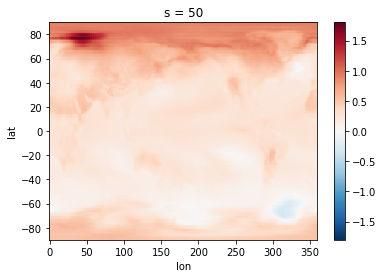

In [58]:
)

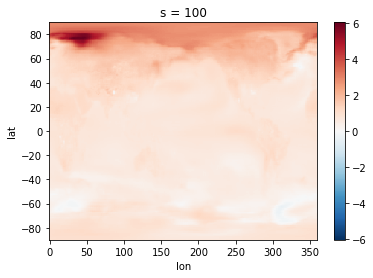

In [53]:
conv_enroads['Current Scenario'].isel(s = 100).plot()

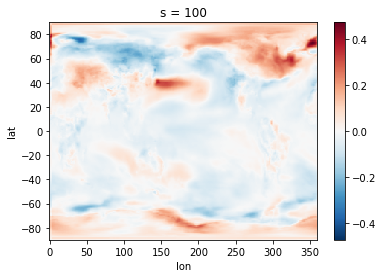

In [163]:
(conv_1pct_mean['2p1_delay'].isel(s = 100) - conv_1pct_mean['2p2'].isel(s = 100)).plot()